In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
val = pd.read_csv('./merged/val.final_with_metrics.csv')
test = pd.read_csv('./merged/test.final_with_metrics.csv')
def filter_error_rows(df: pd.DataFrame, focus_col: str) -> pd.DataFrame:
    mask = df[focus_col].astype(str).str.contains(r"<error:", case=False, na=False)
    cleaned = df.loc[~mask].copy()
    return cleaned
val = filter_error_rows(val, focus_col="SynCodonLM_predicted_seq")
test = filter_error_rows(test, focus_col="SynCodonLM_predicted_seq")

In [3]:
val.columns

Index(['type', 'organism', 'protein_seq', 'ground_truth_seq',
       'ground_truth_gc', 'ground_truth_CSI', 'ground_truth_ENC',
       'ground_truth_minmax_mean', 'CodonTranslator_predicted_seq',
       'CodonTranslator_predicted_gc', 'CodonTranslator_predicted_CSI',
       'CodonTranslator_predicted_ENC',
       'CodonTranslator_predicted_codon_similarity',
       'CodonTranslator_minmax_mean', 'CodonTranslator_minmax_dtw',
       'CodonTransformer_predicted_seq', 'CodonTransformer_predicted_gc',
       'CodonTransformer_predicted_CSI', 'CodonTransformer_predicted_ENC',
       'CodonTransformer_predicted_codon_similarity',
       'CodonTransformer_minmax_mean', 'CodonTransformer_minmax_dtw',
       'SynCodonLM_predicted_seq', 'SynCodonLM_predicted_gc',
       'SynCodonLM_predicted_CSI', 'SynCodonLM_predicted_ENC',
       'SynCodonLM_predicted_codon_similarity', 'SynCodonLM_minmax_mean',
       'SynCodonLM_minmax_dtw', 'HFC_predicted_seq', 'HFC_predicted_gc',
       'HFC_predicted_CSI'

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.collections import PolyCollection
from pandas.api.types import CategoricalDtype

# -------------------- config --------------------
METHODS = ["CodonTranslator", "CodonTransformer", "SynCodonLM"]

# palette (same base you used; last color reserved for GT)
_base = sns.color_palette()
_colors = [_base[i] for i in [0, 1, 4, 3, 5, 6, 9]]
PALETTE = {METHODS[0]: _colors[0], METHODS[1]: _colors[1], METHODS[2]: _colors[2]}
GT_COLOR = _colors[-1]            # colorful, not black
PALETTE_WITH_GT = {**PALETTE, "Ground truth": GT_COLOR}

def setup_theme():
    sns.set_style("white")  # clean background (no grid)
    rcParams.update({
        "axes.edgecolor": "black",
        "axes.linewidth": 0.25,
        "xtick.color": "black",
        "ytick.color": "black",
        "text.color": "black",
        "figure.facecolor": "white",
        "axes.facecolor": "white",
    })

def style_axes(ax, show_y: bool, spine_lw: float = 0.25):
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(show_y)
    if not show_y:
        ax.tick_params(axis="y", left=False, labelleft=False)
    for side, spine in ax.spines.items():
        if spine.get_visible():
            spine.set_linewidth(spine_lw)
            spine.set_color("black")

# --------- helpers: melt + clip tails to 95% per method ----------
def clip_by_quantile(df_long: pd.DataFrame, group_col: str, value_col: str,
                     low_q: float = 0.025, high_q: float = 0.975) -> pd.DataFrame:
    qs = df_long.groupby(group_col)[value_col].quantile([low_q, high_q]).unstack()
    def _mask(g):
        lo, hi = qs.loc[g.name, [low_q, high_q]]
        return (g[value_col] >= lo) & (g[value_col] <= hi)
    return df_long.groupby(group_col, group_keys=False).apply(lambda g: g[_mask(g)])

def melt_for_violins(df: pd.DataFrame, metric: str):
    parts = []
    if metric == "CSI":
        if "ground_truth_CSI" in df.columns:
            gt = df[["ground_truth_CSI"]].rename(columns={"ground_truth_CSI": "value"}).copy()
            gt["method"] = "Ground truth"
            parts.append(gt)
        for m in METHODS:
            col = f"{m}_predicted_CSI"
            if col in df.columns:
                t = df[[col]].rename(columns={col: "value"}).copy()
                t["method"] = m
                parts.append(t)
        order = ["Ground truth"] + METHODS
        cmap = PALETTE_WITH_GT
        ylims = (0, 1)
        ylabel = "CSI"
    elif metric == "codon_similarity":
        for m in METHODS:
            col = f"{m}_predicted_codon_similarity"
            if col in df.columns:
                t = df[[col]].rename(columns={col: "value"}).copy()
                t["method"] = m
                parts.append(t)
        order = METHODS
        cmap = PALETTE
        ylims = (0, 1)
        ylabel = "Codon similarity"
    elif metric == "minmax_dtw":
        for m in METHODS:
            col = f"{m}_minmax_dtw"
            if col in df.columns:
                t = df[[col]].rename(columns={col: "value"}).copy()
                t["method"] = m
                parts.append(t)
        order = METHODS
        cmap = PALETTE
        ylims = (0, None)    # start at 0
        ylabel = "DTW distance"
    else:
        raise ValueError("Unknown metric.")

    long_df = pd.concat(parts, ignore_index=True)
    long_df = long_df[pd.to_numeric(long_df["value"], errors="coerce").notna()].copy()
    long_df["value"] = long_df["value"].astype(float)
    long_df["method"] = long_df["method"].astype(CategoricalDtype(categories=order, ordered=True))

    # clip extremes to 2.5–97.5% per method
    long_df = clip_by_quantile(long_df, "method", "value", 0.025, 0.975)
    return long_df, order, cmap, ylims, ylabel

def plot_val_test_violins(val: pd.DataFrame, test: pd.DataFrame,
                          out_eps: str = "supp_val_test_violins.eps"):
    setup_theme()
    fig, axes = plt.subplots(1, 6, figsize=(24, 4), sharey=False)

    metrics = ["CSI", "codon_similarity", "minmax_dtw"] * 2
    dfs = [val, val, val, test, test, test]
    titles = ["CSI", "Codon similarity", "DTW distance"] * 2  # no "Val/Test" in titles

    for i, (ax, metric, df_split, ttl) in enumerate(zip(axes, metrics, dfs, titles)):
        long_df, order, cmap, ylims, ylabel = melt_for_violins(df_split, metric)

        sns.violinplot(
            data=long_df, x="method", y="value", order=order,
            palette=PALETTE_WITH_GT, ax=ax, cut=0, linewidth=.5, scale="width",
        )
        
        if ylims[0] is not None or ylims[1] is not None:
            lo, hi = ax.get_ylim()
            ax.set_ylim(bottom=ylims[0] if ylims[0] is not None else lo,
                        top=ylims[1] if ylims[1] is not None else hi)

        ax.set_title(ttl, fontsize=18, pad=6, color="black")
        ax.set_xlabel("")
        ax.set_ylabel(ylabel, fontsize=16)              # <-- always keep y label
        ax.tick_params(axis="x", rotation=20, labelsize=12)
        style_axes(ax, show_y=True)        # <-- always show left y-axis

    fig.tight_layout()
    fig.savefig(out_eps, format="eps", bbox_inches="tight")
    return fig

# ---------- Figure 2: 6-panel ENC–GC KDE (no Val/Test labels) ----------
def enc_gc_for_kde(df: pd.DataFrame, method: str) -> pd.DataFrame:
    frames = []
    if {"ground_truth_gc", "ground_truth_ENC"}.issubset(df.columns):
        gt = df[["ground_truth_gc", "ground_truth_ENC"]].rename(
            columns={"ground_truth_gc": "gc", "ground_truth_ENC": "enc"})
        gt["which"] = "Ground truth"
        frames.append(gt)
    gc_col, enc_col = f"{method}_predicted_gc", f"{method}_predicted_ENC"
    if gc_col in df.columns and enc_col in df.columns:
        t = df[[gc_col, enc_col]].rename(columns={gc_col: "gc", enc_col: "enc"})
        t["which"] = method
        frames.append(t)
    out = pd.concat(frames, ignore_index=True)
    out = out[pd.to_numeric(out["gc"], errors="coerce").notna() &
              pd.to_numeric(out["enc"], errors="coerce").notna()].copy()
    out["gc"] = out["gc"].astype(float)
    out["enc"] = out["enc"].astype(float)
    return out

def plot_val_test_kde(val: pd.DataFrame, test: pd.DataFrame,
                      out_eps: str = "supp_val_test_kde.eps",
                      levels: int = 6):
    setup_theme()
    fig, axes = plt.subplots(1, 6, figsize=(24, 4), sharex=True, sharey=True)

    panels = [(METHODS[0], val), (METHODS[1], val), (METHODS[2], val),
              (METHODS[0], test), (METHODS[1], test), (METHODS[2], test)]

    # shared ENC limits
    all_enc = []
    for df_split in [val, test]:
        for m in METHODS:
            ec = f"{m}_predicted_ENC"
            if ec in df_split.columns:
                all_enc.append(df_split[ec].astype(float))
        if "ground_truth_ENC" in df_split.columns:
            all_enc.append(df_split["ground_truth_ENC"].astype(float))
    enc_series = pd.concat(all_enc, ignore_index=True).dropna()
    enc_lo = float(np.nanquantile(enc_series, 0.01)) if not enc_series.empty else 15.0
    enc_hi = float(np.nanquantile(enc_series, 0.99)) if not enc_series.empty else 65.0
    enc_lo = min(15.0, enc_lo)
    enc_hi = max(65.0, enc_hi)

    for i, (method, df_split) in enumerate(panels):
        ax = axes[i]
        dat = enc_gc_for_kde(df_split, method)
        if not dat.empty:
            sm_m = dat[dat["which"] == method]
            sm_g = dat[dat["which"] == "Ground truth"]
            if not sm_m.empty:
                sns.kdeplot(data=sm_m, x="gc", y="enc", ax=ax, levels=levels,
                            fill=False, bw_adjust=1.0, color=PALETTE[method], linewidth=0.5)
            if not sm_g.empty:
                sns.kdeplot(data=sm_g, x="gc", y="enc", ax=ax, levels=levels,
                            fill=False, bw_adjust=1.0, color=GT_COLOR, linewidth=0.5)

        ax.set_xlim(0, 1)
        ax.set_ylim(enc_lo, enc_hi)
        ax.set_title(method, fontsize=18, pad=6, color="black")
        ax.set_xlabel("GC", fontsize=16)
        show_y = (i == 0) or (i == 3)
        if show_y:
            ax.set_ylabel("ENC", fontsize=16)
        else:
            ax.set_ylabel("")
        style_axes(ax, show_y=show_y)

    fig.tight_layout()
    fig.savefig(out_eps, format="eps", bbox_inches="tight")
    return fig




/var/folders/3f/llq03h9s01b8gp_qjrrnx_l40000gn/T/ipykernel_31226/4269012162.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  qs = df_long.groupby(group_col)[value_col].quantile([low_q, high_q]).unstack()
/var/folders/3f/llq03h9s01b8gp_qjrrnx_l40000gn/T/ipykernel_31226/4269012162.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df_long.groupby(group_col, group_keys=False).apply(lambda g: g[_mask(g)])
/var/folders/3f/llq03h9s01b8gp_qjrrnx_l40000gn/T/ipykernel_31226/4269012162.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a futur

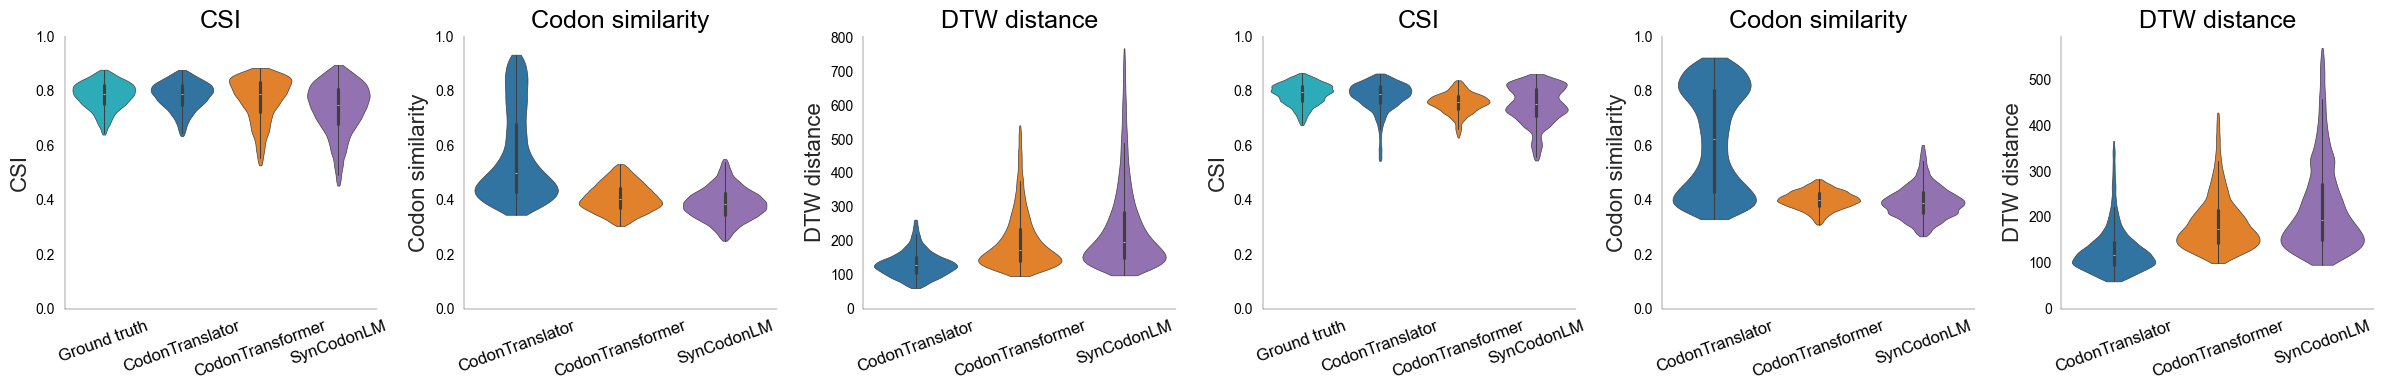

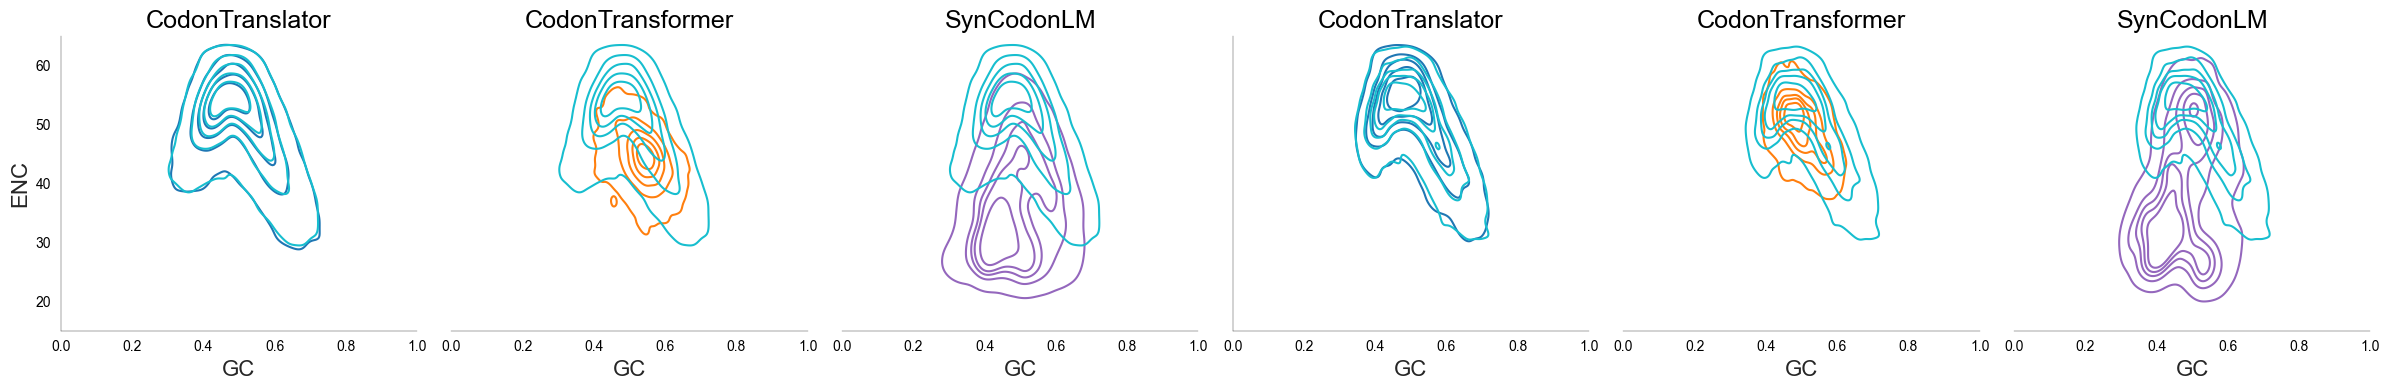

In [33]:
# -------------------- run --------------------
fig1 = plot_val_test_violins(val, test, out_eps="val_test_violins_trimmed.eps")
fig2 = plot_val_test_kde(val, test, out_eps="val_test_kde.eps")
plt.show()